# **RNN Introduction**


## Importing required libraries


In [126]:
pip install mplfinance


In [127]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [128]:
df = pd.read_csv('/content/traffic.csv')

In [129]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [131]:
df['Junction'].unique()

array([1, 2, 3, 4])

In [132]:
df['DateTime'] = pd.to_datetime(df['DateTime'])



In [133]:
def categorize_hour(hour):
    if 0 <= hour < 6:
        return 'EM'
    elif 6 <= hour < 12:
        return 'M'
    elif 12 <= hour < 18:
        return 'AN'
    elif 18 <= hour < 24:
        return 'N'

# Add the new column based on the hour of the DateTime
df['Period'] = df['DateTime'].dt.hour.apply(categorize_hour)

# Create the four new columns and fill them based on the 'Period' value
df['EM'] = df['Period'].apply(lambda x: 1 if x == 'EM' else 0)
df['M'] = df['Period'].apply(lambda x: 1 if x == 'M' else 0)
df['AN'] = df['Period'].apply(lambda x: 1 if x == 'AN' else 0)
df['N'] = df['Period'].apply(lambda x: 1 if x == 'N' else 0)

# Drop the 'Period' column if you don't need it
df.drop(columns=['Period'], inplace=True)

In [134]:
df.tail()

,DateTime,Junction,Vehicles,ID,EM,M,AN,N
48115,2017-06-30 19:00:00,4,11,20170630194,0,0,0,1
48116,2017-06-30 20:00:00,4,30,20170630204,0,0,0,1
48117,2017-06-30 21:00:00,4,16,20170630214,0,0,0,1
48118,2017-06-30 22:00:00,4,22,20170630224,0,0,0,1
48119,2017-06-30 23:00:00,4,12,20170630234,0,0,0,1


In [135]:
df.head(25)

,DateTime,Junction,Vehicles,ID,EM,M,AN,N
0,2015-11-01 00:00:00,1,15,20151101001,1,0,0,0
1,2015-11-01 01:00:00,1,13,20151101011,1,0,0,0
2,2015-11-01 02:00:00,1,10,20151101021,1,0,0,0
3,2015-11-01 03:00:00,1,7,20151101031,1,0,0,0
4,2015-11-01 04:00:00,1,9,20151101041,1,0,0,0
5,2015-11-01 05:00:00,1,6,20151101051,1,0,0,0
6,2015-11-01 06:00:00,1,9,20151101061,0,1,0,0
7,2015-11-01 07:00:00,1,8,20151101071,0,1,0,0
8,2015-11-01 08:00:00,1,11,20151101081,0,1,0,0
9,2015-11-01 09:00:00,1,12,20151101091,0,1,0,0


In [136]:
# df["Year"]= df['DateTime'].dt.year
# df["Month"]= df['DateTime'].dt.month
# df["Date_no"]= df['DateTime'].dt.day
# df["Hour"]= df['DateTime'].dt.hour
# df["Day"]= df.DateTime.dt.strftime("%A")
# df.head()

In [137]:
df = df[(df['DateTime'].dt.hour >= 12) & (df['DateTime'].dt.hour <= 17)]

In [138]:
df.head(8)

,DateTime,Junction,Vehicles,ID,EM,M,AN,N
12,2015-11-01 12:00:00,1,16,20151101121,0,0,1,0
13,2015-11-01 13:00:00,1,15,20151101131,0,0,1,0
14,2015-11-01 14:00:00,1,16,20151101141,0,0,1,0
15,2015-11-01 15:00:00,1,12,20151101151,0,0,1,0
16,2015-11-01 16:00:00,1,12,20151101161,0,0,1,0
17,2015-11-01 17:00:00,1,16,20151101171,0,0,1,0
36,2015-11-02 12:00:00,1,35,20151102121,0,0,1,0
37,2015-11-02 13:00:00,1,26,20151102131,0,0,1,0


In [139]:
def specific_data(Junction, start, end, start_hour, end_hour):
    Junction_data = df[df['Vehicles'] == Junction]
    date_filtered_data = Junction_data[(Junction_data['DateTime'] > start) & (Junction_data['DateTime'] < end)]
    time_filtered_data = date_filtered_data[
        (date_filtered_data['DateTime'].dt.hour >= start_hour) &
        (date_filtered_data['DateTime'].dt.hour < end_hour)
    ]
    return date_filtered_data

In [140]:
company_name = random.choice(df['Vehicles'].unique().tolist())
# Setting the start and end date
start_date=dt.datetime(2015,11,1)
end_date=dt.datetime(2017,10,30)

start_hour = 12
end_hour = 17

# Calling our function
specific_df = specific_data(company_name, start_date, end_date, start_hour, end_hour)


In [141]:
# df['day_of_week'] = df['DateTime'].dt.dayofweek

## Visualization

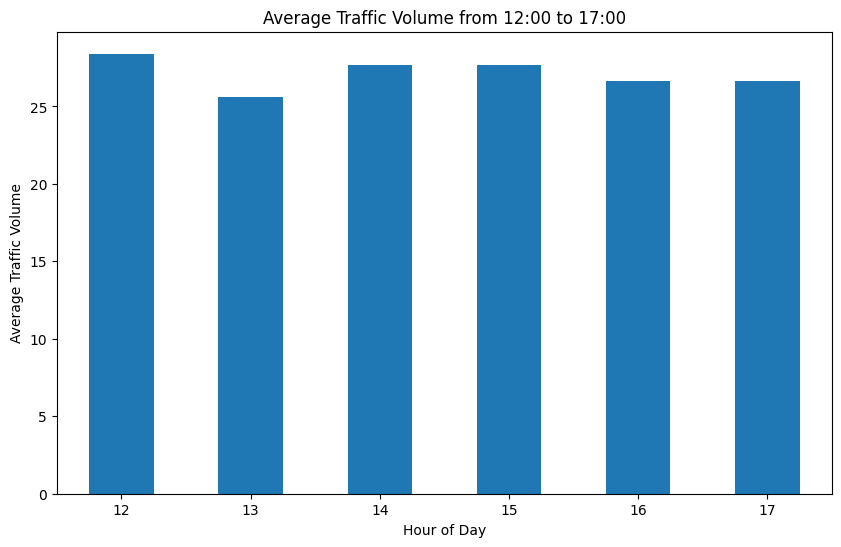

In [142]:
# Group data by hour and calculate the mean traffic volume
hourly_traffic = df.groupby(df['DateTime'].dt.hour)['Vehicles'].mean()

# Plot the hourly traffic
plt.figure(figsize=(10, 6))
hourly_traffic.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume from 12:00 to 17:00')
plt.xticks(rotation=0)
plt.show()


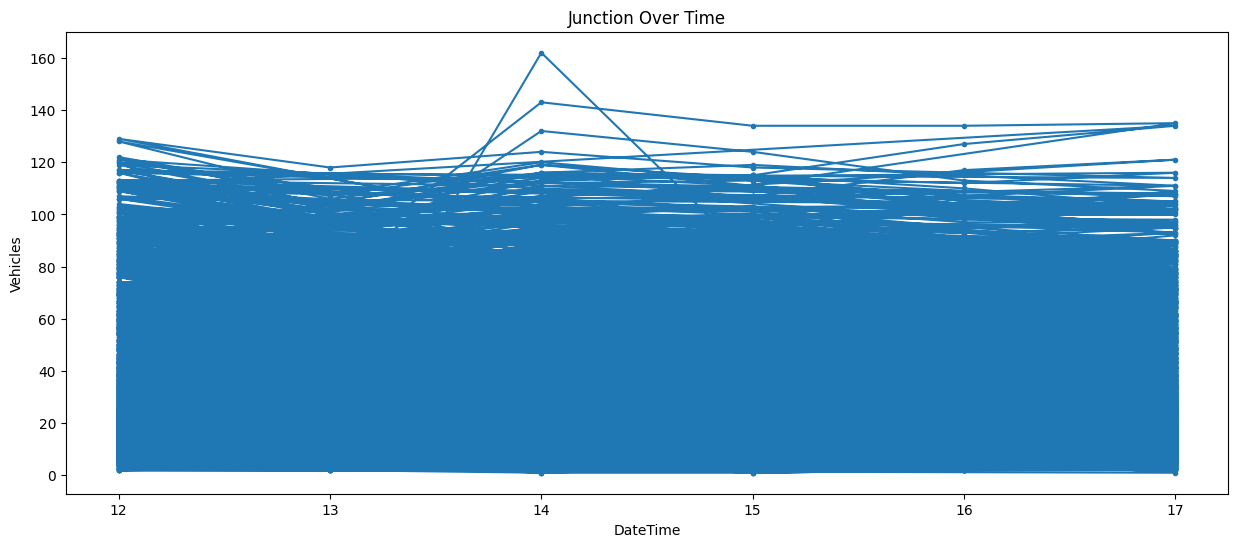

In [143]:
# df['DateTime'] = pd.to_datetime(df['DateTime'])
plt.figure(figsize=(15, 6))
plt.plot((df['DateTime'].dt.hour), df['Vehicles'], marker='.')
plt.title('Junction Over Time')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
# plt.xticks(ticks=np.arange(6), labels=['12', '13', '14', '15', '16', '17',])
# plt.grid(True)
plt.show()

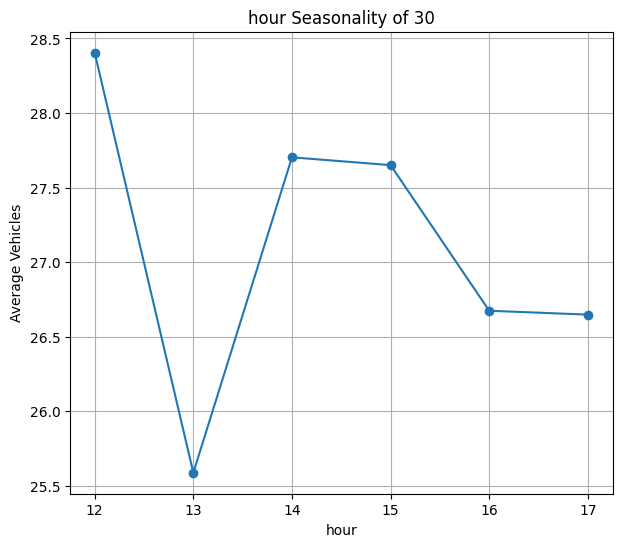

In [144]:
# specific_df['DateTime'] = specific_df['DateTime'].dt.month

hour_average = df.groupby(df['DateTime'].dt.hour)['Vehicles'].mean()

plt.figure(figsize=(7, 6))
plt.plot(hour_average.index, hour_average.values, marker='o')
plt.title(f'hour Seasonality of {Junction_level}')
plt.xlabel('hour')
plt.ylabel('Average Vehicles')
# Adjust the number of ticks and labels to match
# plt.xticks(range(1, 7), ['12', '13', '14', '15', '16', '17'])
plt.grid(True)
plt.show()

## Split the data into train and test

In [145]:
new_df = df['Vehicles'].values

In [146]:
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [147]:
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [148]:
n_past = 20

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [149]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(9604, 20)
(9604,)


Testing set size:-
(2386, 20)
(2386,)


(None, None)

In [150]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Modeling


In [151]:
model = Sequential()

model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, return_sequences=True,))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)             │ (None, 20, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 20, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [153]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our RNN model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1131 - val_loss: 0.0011
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0086 - val_loss: 0.0011
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0047 - val_loss: 0.0011
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 5/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 6/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 7/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 8/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 9/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 10/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 11/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 12/100
301/301 ━━━━━━━━━

In [154]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [155]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [156]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

38.08974861143722
17.71616735769774


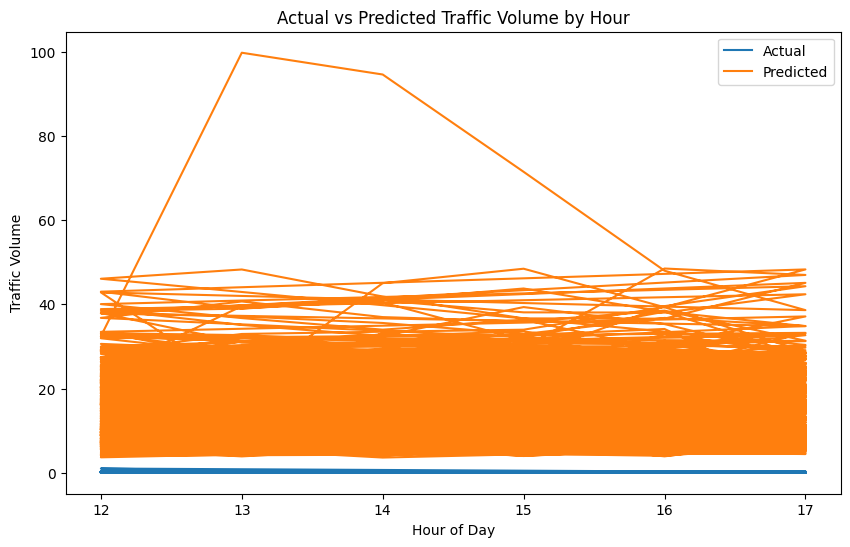

In [157]:
# prompt: Visualization of predct by hour

import matplotlib.pyplot as plt
# Assuming 'test_predict' contains hourly predictions and 'filtered_df' has the corresponding DateTime values
# Extract the hour from DateTime for the test set, ensuring it aligns with y_test
test_hours = filtered_df['DateTime'][train_size:train_size + len(y_test)].dt.hour # Adjust the slicing to match y_test length

# Plot the actual vs predicted values by hour
plt.figure(figsize=(10, 6))
plt.plot(test_hours, y_test, label='Actual')
plt.plot(test_hours, test_predict, label='Predicted')
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Predicted Traffic Volume by Hour')
plt.legend()
plt.show()

## Visualization of results


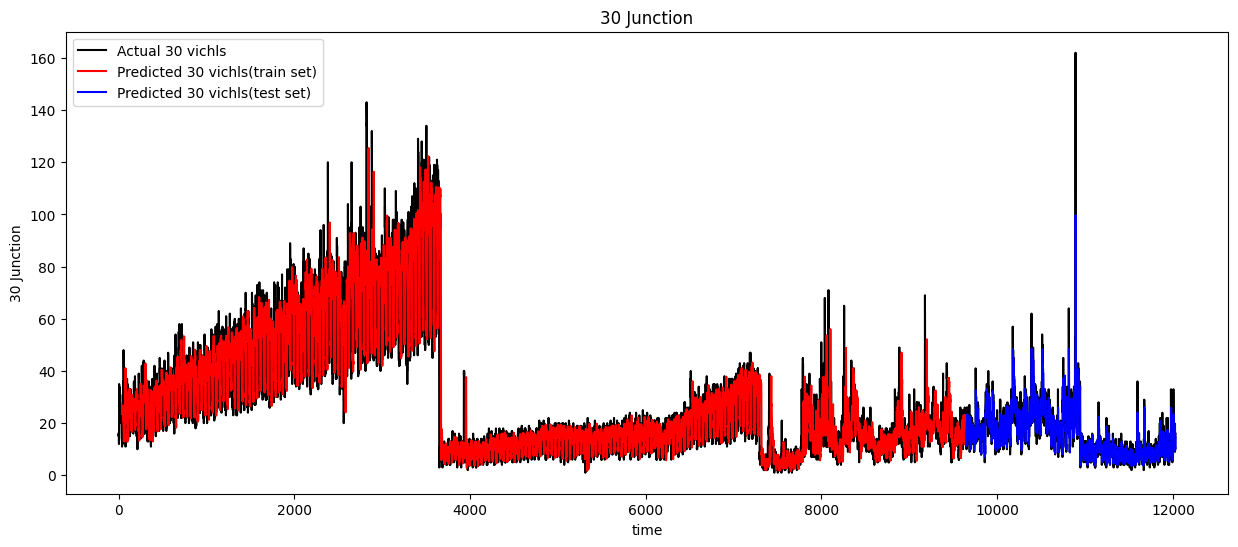

In [160]:
# Set the number of previous time steps to consider for plotting
look_back = 40

trainPredictPlot = np.empty_like(new_df, dtype=np.float64)  # Ensure the array has a float data type
trainPredictPlot[:] = np.nan  # Fill the array with NaN

# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()




testPredictPlot = np.empty_like(new_df, dtype=np.float64)  # Ensure the array has a float data type
testPredictPlot[:] = np.nan  # Fill the array with NaN

# Calculate the starting index for the test predictions
test_start = len(new_df) - len(test_predict)

# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:test_start + len(test_predict)] = test_predict.flatten()


# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {Junction_level} vichls")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {Junction_level} vichls(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {Junction_level} vichls(test set)")

plt.title(f"{Junction_level} Junction")
plt.xlabel("time")
plt.ylabel(f"{Junction_level} Junction")

plt.legend()
plt.show()

In [159]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted  Junction  = {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predictions for the next 10 days:
Day 1: Predicted  Junction  = 14.7614164352417
Day 2: Predicted  Junction  = 13.742494583129883
Day 3: Predicted  Junction  = 14.363914489746094
Day 4: Predicted  Junction  = 13.546910285949707
Day 5: Predicted  Junction  = 14.26077651977539
Day 6: Predicted  Junction  = 14.285683631896973
Day 7: Predicted  Junction  = 14.12928581237793
Day 8: Predicted  Junction  = 15.131217002868652
Day 9: Predicted  Junction  = 15.1046781539917
Day 10: Predicted  Junction  = 15.315120697021484
